## Spectral Energy Distribution (SED) Modeling with PyMCMC

This notebook demonstrates how to perform Bayesian inference on a complex physical model. We focus on a Spectral Energy Distribution (SED) common in astrophysics, which combines a continuum component and an emission line. We will simulate noisy observational data and use MCMC (Markov Chain Monte Carlo) to recover the underlying physical parameters.

### 1. Environment Setup
We begin by importing the required libraries. `numpy` handles numerical computations, `matplotlib` is used for plotting, and `PyMCMC` provides the specialized classes for Bayesian fitting and analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyMCMC import FunctionFitter, Prior, MCMCAnalyzer

### 2. Defining the Physical Model

Our SED model consists of two distinct components:

* **The Continuum** : Represented by a power-law with an exponential cutoff ($Anorm \cdot x^{-\alpha} \cdot e^{-x/x_{cut}}$).
* **The Emission Line** : Represented by a Gaussian profile.

This results in 6 free parameters: normalization, spectral index, energy cutoff, and the line's amplitude, position, and width.

In [2]:
def complex_sed_model(x, params):
    """
	SED model combining a power-law continuum with an exponential cutoff and a Gaussian emission line.
	"""
    Anorm, alpha, x_cut, line_amp, line_center, line_sigma = params
    continuum = Anorm * (x**-alpha) * np.exp(-x / x_cut)
    line = line_amp * np.exp(-0.5 * ((x - line_center) / line_sigma)**2)
    return continuum + line

### 3. Data Simulation and Visualization

To test our algorithm, we generate synthetic data. We define "true" values for our parameters, calculate the model flux, and add Gaussian noise to simulate real-world observational uncertainties ($y_{err}$).

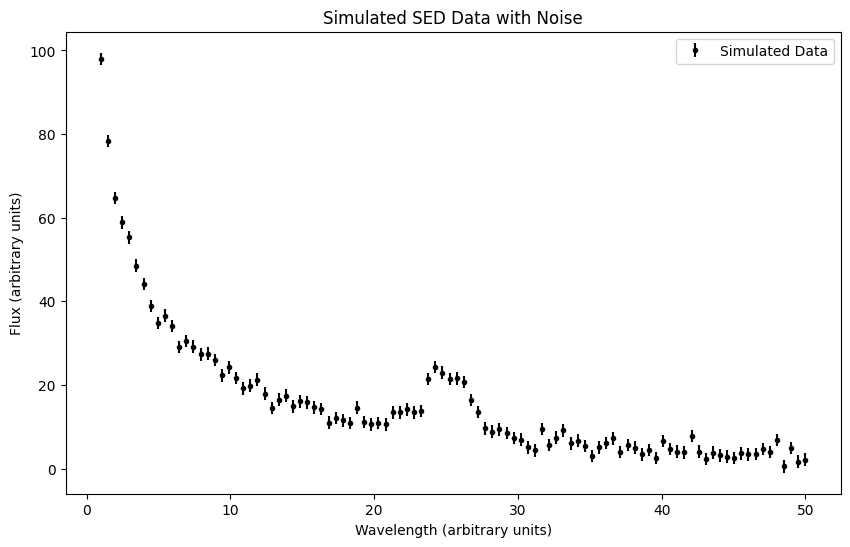

In [3]:
x_data = np.linspace(1, 50, 100)
true_params = [100.0, 0.5, 30.0, 15.0, 25.0, 1.5]
y_err_val = 1.5
y_data = complex_sed_model(x_data, true_params) + np.random.normal(0, y_err_val, size=len(x_data))
y_err = np.ones_like(x_data) * y_err_val

fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(x_data, y_data, yerr=y_err, fmt='ok', label='Simulated Data', markersize=3)
ax.set_xlabel('Wavelength (arbitrary units)')
ax.set_ylabel('Flux (arbitrary units)')
ax.set_title('Simulated SED Data with Noise')
ax.legend()
plt.show()

### 4. Bayesian Framework Configuration
In this step, we prepare the inference engine:

Priors: We define our prior beliefs. We use Uniform priors for most parameters (assuming equal probability within a range) and a Gaussian prior for the line center, simulating a case where we have some prior spectral knowledge of the source.

FunctionFitter: This object links the model, the data, and the priors. We also enable covariance adaptation (`adapt_every=100`) to improve sampling efficiency.

In [4]:
priors = [
        Prior('uniform', (50, 150)),      # Anorm : continuum normalization
        Prior('uniform', (0.1, 1.5)),     # alpha : spectral index
        Prior('uniform', (10, 100)),      # x_cut : high-energy cutoff
        Prior('uniform', (0, 30)),        # line_amp : line amplitude
        Prior('gaussian', (25.0, 0.5)),   # line_center : position (strong prior at 25 +/- 0.5)
        Prior('uniform', (0.1, 5))        # line_sigma : line width
    ]
    
param_names = ["Anorm", "alpha", "x_cut", "line_amp", "line_center", "line_sigma"]

fitter = FunctionFitter(complex_sed_model, x_data, y_data, y_err=y_err, 
						priors=priors, adapt_every=100)

### 5. MCMC Sampling (DRAM Algorithm)
We run the sampler using the DRAM (Delayed Rejection Adaptive Metropolis) method. This algorithm is particularly robust for non-linear models as it dynamically updates its proposal distribution to match the shape of the posterior distribution.

In [5]:
initial_guess = [90.0, 0.7, 40.0, 10.0, 24.5, 1.0]
    
chain = fitter.fit(
	initial_params=initial_guess, 
	n_iterations=50000, 
	method='DRAM',
	show_progress=True
)

MCMC Sampling: 100%|██████████| 50000/50000 [00:01<00:00, 28931.65it/s]


### 6. Posterior Analysis and Results
Finally, we analyze the MCMC chains. We compute the **MAP (Maximum A Posteriori)** estimates and the **95% HDI (Highest Density Interval)** to quantify uncertainties. We also generate a **Posterior Predictive plot**, which overlays samples from our chain onto the original data to visually assess the quality of the fit.

Automatic Burn-in detected: 50.0%

Parameter       | Mean ± std           | HDI 95%              | MAP       
-------------------------------------------------------------------------------------
Anorm           | 101.3194 ± 1.0970    | [99.150, 103.462]    | 101.2878
alpha           | 0.5282 ± 0.0135      | [0.501, 0.554]       |   0.5247
x_cut           | 34.0514 ± 2.2835     | [29.632, 38.496]     |  33.2403
line_amp        | 14.5993 ± 0.7612     | [13.090, 16.084]     |  14.6690
line_center     | 25.0638 ± 0.0886     | [24.881, 25.234]     |  25.0907
line_sigma      | 1.5530 ± 0.1012      | [1.364, 1.758]       |   1.5563

 Minimum reduced Chi2: 1.085
 AIC: 378.894 | BIC: 394.525 | WAIC: 375.704


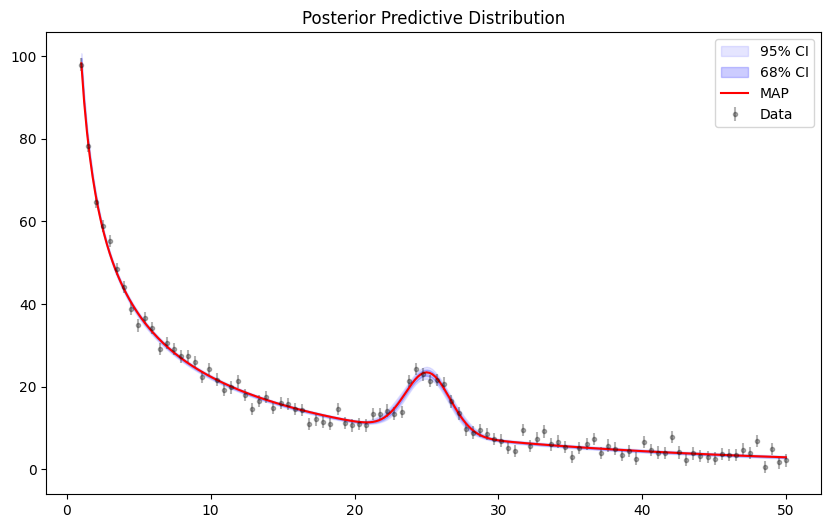

In [6]:
analyzer = MCMCAnalyzer(chain, fitter)
analyzer.print_summary(param_names=param_names)
analyzer.plot_posterior_predictive(n_samples=1000)


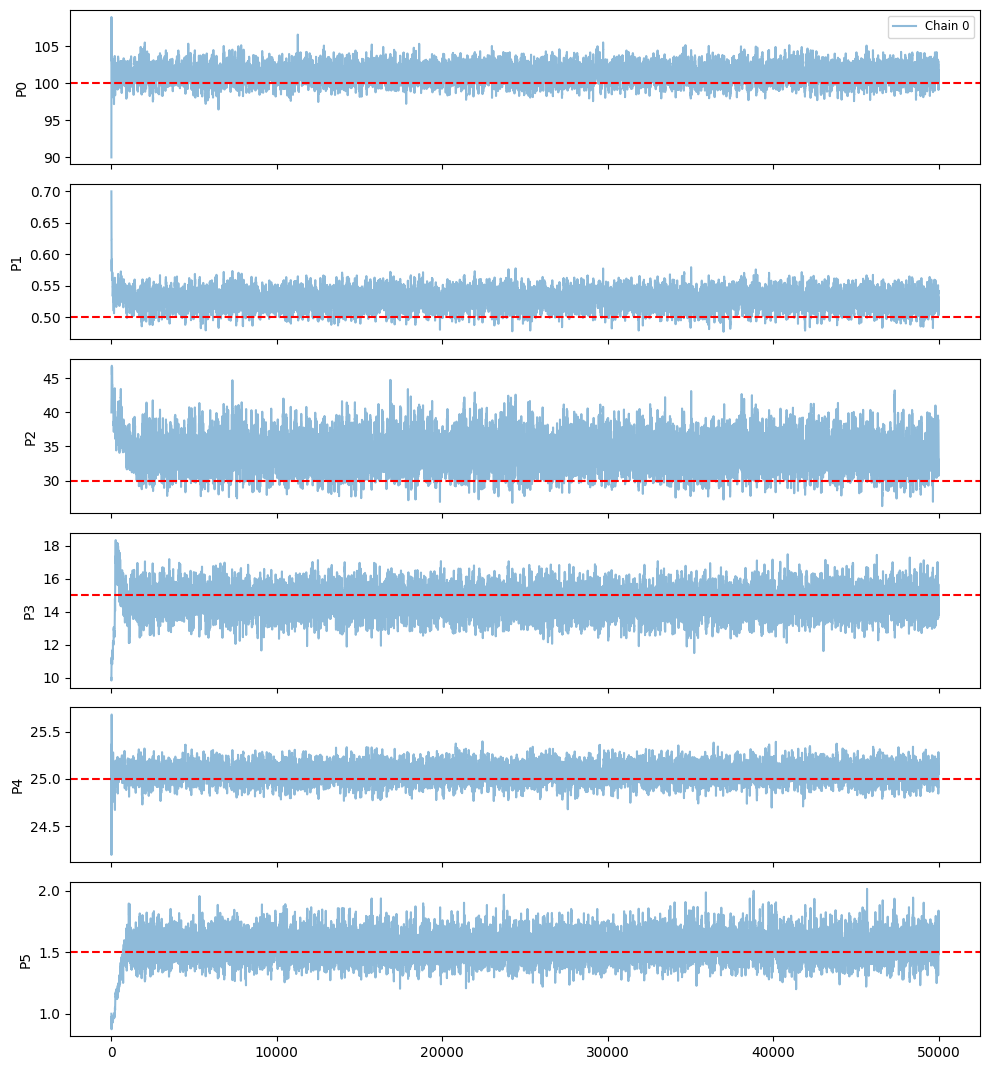

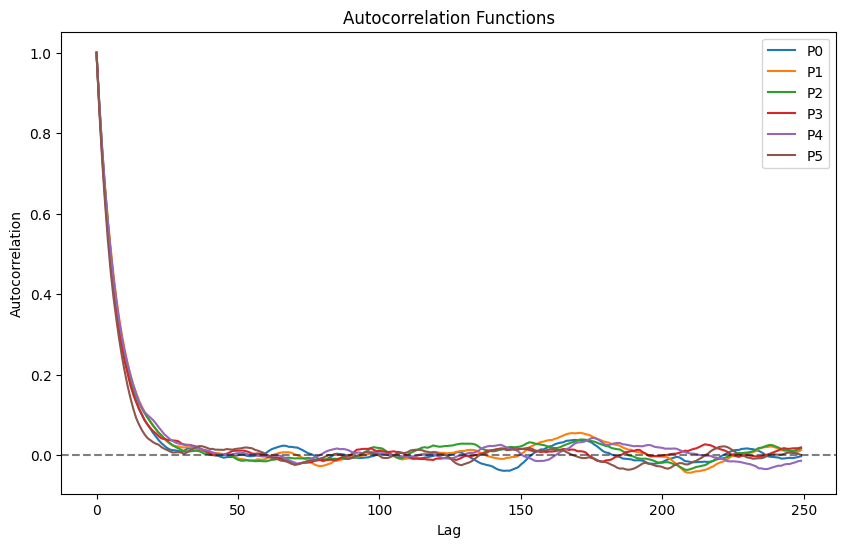

In [7]:
analyzer.plot_traces(true_params=true_params)
    
analyzer.plot_autocorrelation(max_lag=250)

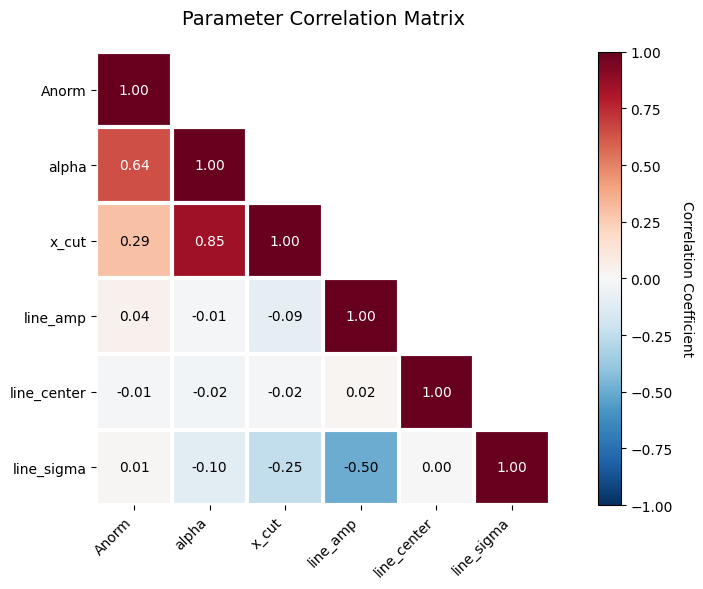

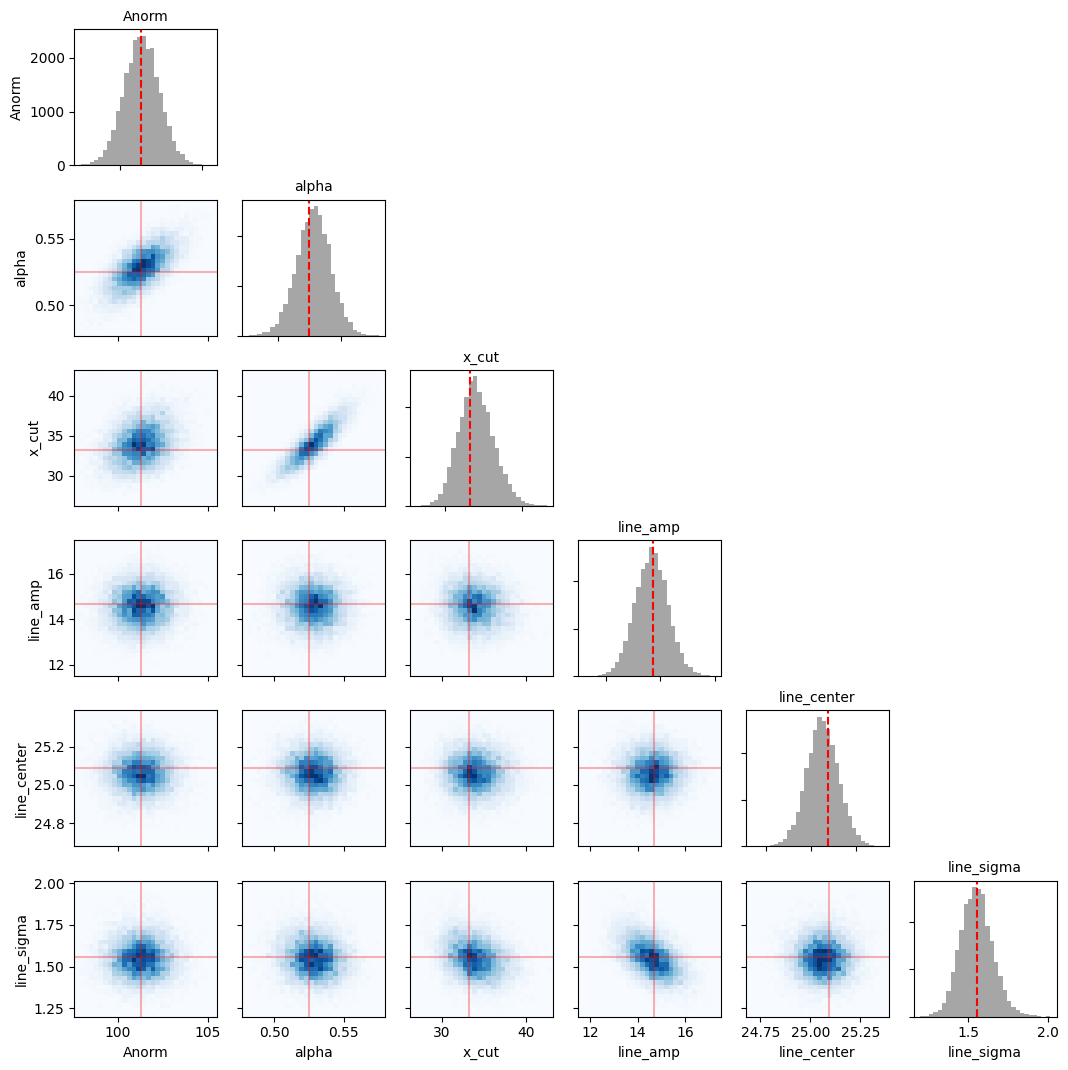

In [8]:
analyzer.plot_correlation_matrix(param_names=param_names)

analyzer.plot_corner(param_names=param_names)